# Ejercicio 4: Modelo Probabilístico

## Objetivo de la práctica
- Comprender los componentes del modelo vectorial mediante cálculos manuales y observación directa.
- Aplicar el modelo de espacio vectorial con TF-IDF para recuperar documentos relevantes.
- Comparar la recuperación con BM25 frente a TF-IDF.
- Analizar visualmente las diferencias entre los modelos.
- Evaluar si los rankings generados son consistentes con lo que considerarías documentos relevantes.

## Parte 0: Carga del Corpus

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
newsgroupsdocs = newsgroups.data[:1000]

## Parte 1: Cálculo de TF, DF, IDF y TF-IDF

### Actividad
1. Utiliza el corpus cargado.
2. Construye la matriz de términos (TF), y calcula la frecuencia de documentos (DF)
3. Calcula TF-IDF utilizando sklearn.
4. Visualiza los valores en un DataFrame para analizar las diferencias entre los términos.

In [3]:
# Construir la matriz de términos TF
vectorizer = CountVectorizer()
X_counts = vectorizer.fit_transform(newsgroupsdocs)

# Obtener términos y construir el DataFrame de vectorizer (matríz TF)
terms = vectorizer.get_feature_names_out()
tf_df = pd.DataFrame(X_counts.toarray(), columns=terms)

# Calcular la frecuencia de documentos DF
df = np.sum(X_counts.toarray() > 0, axis=0)
df_series = pd.Series(df, index=terms, name='DF')

# Calcular TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(newsgroupsdocs)

# Obtener términos y construir el DataFrame de tfidf_vectorizer (matríz TF-IDF)
terms_tfidf = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=terms_tfidf)

# Obtener los IDFs a partir de la matriz TF-IDF
idf_values = tfidf_vectorizer.idf_
idf_df = pd.DataFrame({'Term': terms_tfidf, 'IDF': idf_values})
top_idf = idf_df.sort_values(by='IDF', ascending=False).head(100) # Aquí delimita a 100 términos


In [4]:
# Visualizar los valores
print("TF (frecuencia de términos) - primeras filas:")
print(tf_df.head())

print("\nDF (frecuencia de documentos) - top 10 términos:")
print(df_series.sort_values(ascending=False).head())

print("\nTF-IDF - primeras filas:")
print(tfidf_df.head())

print("\nTop 10 términos con mayor IDF:")
print(top_idf)


TF (frecuencia de términos) - primeras filas:
   00  000  00000000  00000074  0002  0029  0040000d  0055  00900001  01  ...  \
0   0    0         0         0     0     0         0     0         0   0  ...   
1   0    0         0         0     0     0         0     0         0   0  ...   
2   0    0         0         0     0     0         0     0         0   0  ...   
3   0    0         0         0     0     0         0     0         0   0  ...   
4   0    0         0         0     0     0         0     0         0   0  ...   

   zooms  zubkoff  zubov  zuki  zur  zurbrin  zv  zviq  zx900  zzzzzzt  
0      0        0      0     0    0        0   0     0      0        0  
1      0        0      0     0    0        0   0     0      0        0  
2      0        0      0     0    0        0   0     0      0        0  
3      0        0      0     0    0        0   0     0      0        0  
4      0        0      0     0    0        0   0     0      0        0  

[5 rows x 18367 columns]

DF

## Parte 2: Ranking de documentos usando TF-IDF

### Actividad

1. Dada una consulta, construye el vector de consulta
2. Calcula la similitud coseno entre la consulta y cada documento usando los vectores TF-IDF
3. Genera un ranking de los documentos ordenados por relevancia.
4. Muestra los resultados en una tabla.

In [5]:
# Definir la consulta
query = "information"

# Vectorizar la consulta
query_vector = vectorizer.transform([query])

# Calcular la similitud coseno entre la consulta y todos los documentos
similarities = cosine_similarity(query_vector, X_tfidf).flatten()

# Crear un DataFrame con los resultados ordenados de manera descendente
ranking = pd.DataFrame({
    'DocID': range(len(newsgroupsdocs)),
    'Similarity': similarities,
    'Text': newsgroupsdocs
})
# Aquí se ordenan descendentemente
ranking = ranking.sort_values(by='Similarity', ascending=False).reset_index(drop=True)

# Mostrar los 10 documentos más relevantes
pd.set_option('display.max_colwidth', 200)
print(ranking[['DocID', 'Similarity', 'Text']].head(10)) # Aquí se limitan a 10 documentos



   DocID  Similarity  \
0    656    0.247293   
1    299    0.198563   
2     32    0.194525   
3    738    0.180158   
4    124    0.159474   
5    624    0.147370   
6    799    0.141004   
7     49    0.136182   
8    408    0.132289   
9    717    0.128509   

                                                                                                                                                                                                      Text  
0  Hello everybody,\n\nI am searching for (business) information of Motif applications, to create a\nTOP-30 of most used WordProcessors, Spreadsheets, Drawing programs, Schedulers\nand Fax programs, ...  
1  This may be a stupid question, but how does the government know which keys\nto ask for?\n\nWill owners be required to REGISTER their phones, faxes, modems, etc.,\nand inform the government when th...  
2                          Has anybody generated an X server for Windows NT?  If so, are you willing\nto share your conf

## Parte 3: Ranking con BM25

### Actividad

1. Implementa un sistema de recuperación usando el modelo BM25.
2. Usa la misma consulta del ejercicio anterior.
3. Calcula el score BM25 para cada documento y genera un ranking.
4. Compara manualmente con el ranking de TF-IDF.

In [6]:
pip install rank_bm25

Note: you may need to restart the kernel to use updated packages.


In [7]:
from rank_bm25 import BM25Okapi

# Tokenizamos
tokenized_corpus = [doc.lower().split() for doc in newsgroupsdocs]
bm25_docs = BM25Okapi(tokenized_corpus)

tokenized_query = query.lower().split()
bm25_scores = bm25_docs.get_scores(tokenized_query)        # ndarray


# UNIFICAR RESULTADOS EN UN SOLO DataFrame

df = pd.DataFrame({
    'Docs'       : newsgroupsdocs,
    'ScoresBM25' : bm25_scores,
    'TF/IDF'     : similarities
})


df = df.sort_values(by='ScoresBM25', ascending=False).reset_index(drop=True)


# MOSTRAR LOS 10 DOCUMENTOS MÁS RELEVANTES

pd.set_option('display.max_colwidth', 200)
print(df.head(10)[['Docs', 'ScoresBM25', 'TF/IDF']])


                                                                                                                                                                                                      Docs  \
0  Hello everybody,\n\nI am searching for (business) information of Motif applications, to create a\nTOP-30 of most used WordProcessors, Spreadsheets, Drawing programs, Schedulers\nand Fax programs, ...   
1  This may be a stupid question, but how does the government know which keys\nto ask for?\n\nWill owners be required to REGISTER their phones, faxes, modems, etc.,\nand inform the government when th...   
2  }Dillon has published a letter in the Blue Press telling people\n}"How to Bankrupt HCI" by requesting information from them.\n}\n}Last time this idea went around in rec.guns, a couple of people\n}...   
3                       Is there anyone out there running a Chicago National\n\tLeague Ballclub list?  If so, please send me information\n\ton it to...\n\t\t\tandrew@aardvark.u

## Parte 4: Comparación visual entre TF-IDF y BM25

### Actividad

1. Utiliza un gráfico de barras para visualizar los scores obtenidos por cada documento según TF-IDF y BM25.
2. Compara los rankings visualmente.
3. Identifica: ¿Qué documentos obtienen scores más altos en un modelo que en otro?
4. Sugiere: ¿A qué se podría deber esta diferencia?

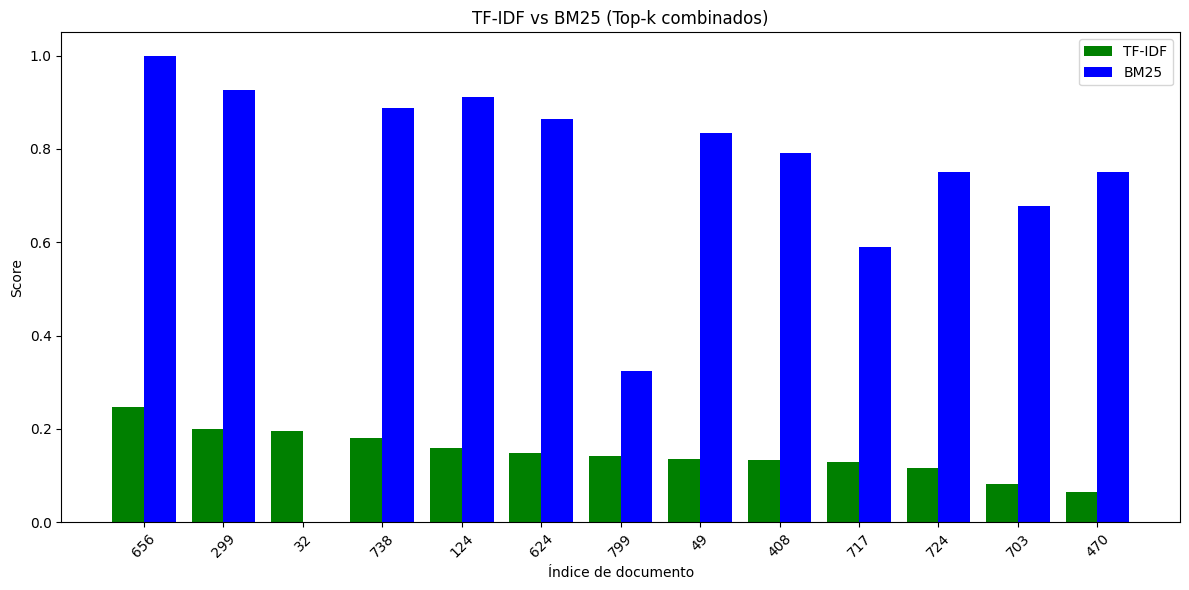

In [8]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# --- Normalización de los scores BM25 ---
scaler = MinMaxScaler()
bm25_scores_normalized = scaler.fit_transform(bm25_scores.reshape(-1, 1)).flatten()

# --- Crear un único DataFrame con todos los datos ---
df_comparacion = pd.DataFrame({
    'DocID': range(len(newsgroupsdocs)),
    'Text': newsgroupsdocs,
    'TF/IDF': similarities,
    'BM25_normalizado': bm25_scores_normalized
})

# --- Obtener los top-k documentos únicos combinando ambos rankings ---
top_k = 10
top_tfidf = df_comparacion.nlargest(top_k, 'TF/IDF')
top_bm25 = df_comparacion.nlargest(top_k, 'BM25_normalizado')

# --- Combinar los top-k de ambos rankings, eliminando duplicados ---
df_top = pd.concat([top_tfidf, top_bm25]).drop_duplicates(subset='DocID').reset_index(drop=True)

# --- Ordenar por relevancia combinada para visualización ---
df_top.sort_values(by=["TF/IDF", "BM25_normalizado"], ascending=False, inplace=True)

# --- Gráfico comparativo ---
x = np.arange(len(df_top))
width = 0.4

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, df_top['TF/IDF'], width, label='TF-IDF', color='green')
plt.bar(x + width/2, df_top['BM25_normalizado'], width, label='BM25', color='blue')

plt.xlabel('Índice de documento')
plt.ylabel('Score')
plt.title('TF-IDF vs BM25 (Top-k combinados)')
plt.xticks(x, df_top['DocID'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## Parte 5: Evaluación con consulta relevante

### Actividad

1. Elige una consulta y define qué documentos del corpus deberían considerarse relevantes.
2. Evalúa Precision@3 o MAP para los rankings generados con TF-IDF y BM25.
3. Responde: ¿Cuál modelo da mejores resultados respecto a tu criterio de relevancia?

In [21]:
query = "information"

relevant_ids = []

for i, doc in enumerate(newsgroupsdocs):
    frequency = doc.lower().split().count(query)
    if frequency > 1:
        relevant_ids.append(i)

print(f"Documentos relevantes: {relevant_ids[:10]} ... (total: {len(relevant_ids)})")

def precision_at_k(ordered_list, relevant, k):
    top_k = ordered_list[:k]
    hits = [1 if doc_id in relevant else 0 for doc_id in top_k]
    return sum(hits) / k

def average_precision(ordered_list, relevant):
    hits = 0
    precision_sum = 0
    for i, doc_id in enumerate(ordered_list):
        if doc_id in relevant:
            hits += 1
            precision_sum += hits / (i + 1)
    if hits == 0:
        return 0
    return precision_sum / hits

# Obtener listas ordenadas de IDs según los modelos
ordered_ids_tfidf = ranking['DocID'].tolist()
ordered_df = df.sort_values(by='ScoresBM25', ascending=False).reset_index()
ordered_ids_bm25 = ordered_df['index'].tolist()

# Precision@3
prec_3_tfidf = precision_at_k(ordered_ids_tfidf, relevant_ids, 3)
prec_3_bm25  = precision_at_k(ordered_ids_bm25, relevant_ids, 3)

# MAP
map_tfidf = average_precision(ordered_ids_tfidf, relevant_ids)
map_bm25  = average_precision(ordered_ids_bm25, relevant_ids)

print(f"Precisión@3 - TF-IDF: {prec_3_tfidf:.3f}")
print(f"Precisión@3 - BM25:   {prec_3_bm25:.3f}")
print(f"MAP - TF-IDF: {map_tfidf:.3f}")
print(f"MAP - BM25:   {map_bm25:.3f}")

best_p3 = "BM25" if prec_3_bm25 > prec_3_tfidf else "TF-IDF"
best_map = "BM25" if map_bm25 > map_tfidf else "TF-IDF"

print(f"\nEl modelo con mejor Precisión@3 es: {best_p3}")
print(f"El modelo con mejor MAP es: {best_map}")


Documentos relevantes: [124, 299, 398, 403, 407, 546, 607, 656, 673, 682] ... (total: 13)
Precisión@3 - TF-IDF: 0.667
Precisión@3 - BM25:   0.000
MAP - TF-IDF: 0.507
MAP - BM25:   0.012

El modelo con mejor Precisión@3 es: TF-IDF
El modelo con mejor MAP es: TF-IDF
